## 二次元データの分類問題
二次元からなるデータ群をcsvを通して扱ってみよう

In [ ]:
#tensorflow バージョン1に変更する必要あり
#2021.08.12から仕様が変更された

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


## 問題



以下のプログラムを実行することで得られるcsvファイルのデータを分類する

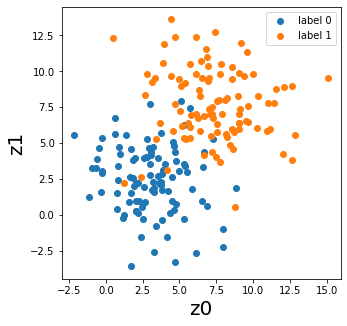

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#2dimentional data csvの作成
def create_2dimdata():
  np.random.seed(1)
  #点群を作る関数
  #create_points(中心点のx座標,y座標,点の数,ノイズの大きさ)
  def create_points(x,y,num,std):
    center = np.array([x,y])
    data = center + np.random.randn(num,2)*std
    return data
  
  #グループ数(5まで)
  num = 2

  #各グループの中心点x座標
  x = [2.5,7.5,2.5,7.5,5]
  #各グループの中心点y座標
  y = [2.5,7.5,7.5,2.5,5]
  #各グループのデータ数
  points_num = [100,100,100,100,100]
  #各グループの散らばり具合
  std = [2.5,2.5,1.5,1.5,1]
  #各グループのラベル
  labels = ['label 0','label 1','label 2','label 3','label 4']

  #各グループのデータ作成
  groups = []
  x_data = np.array([0,0])
  y_data = np.array([],dtype='int8')
  for i in range(num):
    groups.append(create_points(x[i],y[i],points_num[i],std[i]))
    x_data = np.vstack((x_data,groups[i]))
    y_data = np.hstack((y_data,np.full((points_num[i],),i)))
  x_data = np.delete(x_data,0,axis=0)
  
  #データの表示
  plt.figure(figsize=(5,5))
  for i in range(num):
    plt.scatter(groups[i][:,0],groups[i][:,1],label=labels[i])
  plt.xlabel('z0',fontsize=20)
  plt.ylabel('z1',fontsize=20)
  plt.legend()
  plt.show()

  data = pd.DataFrame(x_data,columns=['z0','z1'])
  data['label'] = y_data
  data.to_csv('2DimentionalData.csv',encoding='UTF-8',index=False)

create_2dimdata()

**必要なこと**


*   csvの読み込み
*   x_dataの作成
*   y_target(ordinal data)の作成
*   x_dataの正規化
*   y_data(one-hot data)の作成



### csvファイルの読み込み

In [ ]:
#pd.read_csv('ファイル名')でデータを読み込む
twodimdata = pd.read_csv('2DimentionalData.csv')
twodimdata

,z0,z1,label
0,6.560863,0.970609,0
1,1.179571,-0.182422,0
2,4.663519,-3.253847,0
3,6.862029,0.596983,0
4,3.297598,1.876574,0
...,...,...,...
195,3.933611,11.919900,1
196,6.311568,8.694025,1
197,4.945285,9.486321,1
198,2.817098,9.801538,1


### x_dataの作成

In [ ]:
#データをx_dataに格納する
x_data = twodimdata.loc[:,['z0','z1']]

#pandasで扱われるデータはDataFrame型の変数なので扱いにくい
#→np.ndarray型に変換しよう
#np.array(変換したい変数)で変換できる

#ndarray型に変換
x_data = np.array(x_data)
print(x_data.shape)

(200, 2)


In [ ]:
#x_dataを作ったらあとのために実行
x_data_raw = np.copy(x_data)

### y_target(ordinal data)の作成

In [ ]:
#データをy_targetに格納する
y_target = twodimdata.loc[:,['label']]

#np.ndarray型に変換
y_target = np.array(y_target)
print(y_target.shape)
print('↓変換')

#y_targetは1次元の配列にすると扱いやすい
#→reshape関数で2次元行列から1次元配列に直そう
y_target = y_target.reshape(-1)
print(y_target.shape)

(200, 1)
↓変換
(200,)


### x_dataのゼロ平均正規化

In [ ]:
#x_dataの縦方向平均値を求めてxdata_meanとする
x_data_mean = x_data.mean(axis=0)
#x_dataの縦方向標準偏差を求めてxdata_stdとする
x_data_std = x_data.std(axis=0)

#(data-mean)/stdでゼロ平均正規化
x_data = (x_data - x_data_mean) / x_data_std

print('x_dataの平均')
print(x_data.mean(axis = 0)) #平均がほぼ0になっているか確認
print('\nx_dataの標準偏差')
print(x_data.std(axis = 0)) #標準偏差が1になっているか確認

x_dataの平均
[-7.10542736e-17 -7.10542736e-17]

x_dataの標準偏差
[1. 1.]


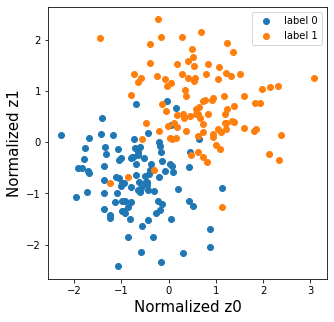

In [ ]:
#正規化したデータの様子をみてみよう
labels = ['label 0','label 1','label 2','label 3','label 4']
plt.figure(figsize=(5,5))
for i in np.unique(y_target):
  plt.scatter(x_data[y_target==i,0],x_data[y_target==i,1],label=labels[i])
plt.xlabel('Normalized z0',fontsize=15)
plt.ylabel('Normalized z1',fontsize=15)
plt.legend(loc='upper right')
plt.show()

### y_data(one-hot data)の作成

In [ ]:
#y_targetのone-hot表現をy_dataに格納
y_data = np.eye(len(np.unique(y_target)))[y_target]
print(y_data.shape)

(200, 2)


### データの分割


入力データ(x_data)と正解データ(y_data)を


*   x_train
*   x_test
*   y_train
*   y_test  
に分ける

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,stratify=y_data)

print('x_trainの形')
print(x_train.shape)
print('\ny_trainの形')
print(y_train.shape)
print('\nx_testの形')
print(x_test.shape)
print('\ny_testの形')
print(y_test.shape)

x_trainの形
(150, 2)

y_trainの形
(150, 2)

x_testの形
(50, 2)

y_testの形
(50, 2)


## 分類器の作成
kerasを使った分類器を実装する

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

binary_model = Sequential([
                           Dense(3,input_shape=(2,),activation='relu'),
                           Dense(len(np.unique(y_target)),activation='softmax')
],name='binary_model')
binary_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "binary_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [ ]:
from keras.optimizers import Adam
binary_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

## 学習

In [ ]:
binary_his = binary_model.fit(x_train,y_train,epochs=200,validation_split=0.2)


Train on 120 samples, validate on 30 samples
Epoch 1/200
120/120 [==============================] - 0s 924us/step - loss: 0.6611 - accuracy: 0.6667 - val_loss: 0.6519 - val_accuracy: 0.6333
Epoch 2/200
120/120 [==============================] - 0s 112us/step - loss: 0.6579 - accuracy: 0.7083 - val_loss: 0.6490 - val_accuracy: 0.6333
Epoch 3/200
120/120 [==============================] - 0s 160us/step - loss: 0.6548 - accuracy: 0.7500 - val_loss: 0.6459 - val_accuracy: 0.6667
Epoch 4/200
120/120 [==============================] - 0s 97us/step - loss: 0.6514 - accuracy: 0.7500 - val_loss: 0.6429 - val_accuracy: 0.6667
Epoch 5/200
120/120 [==============================] - 0s 103us/step - loss: 0.6482 - accuracy: 0.7750 - val_loss: 0.6397 - val_accuracy: 0.6667
Epoch 6/200
120/120 [==============================] - 0s 143us/step - loss: 0.6447 - accuracy: 0.7917 - val_loss: 0.6366 - val_accuracy: 0.6667
Epoch 7/200
120/120 [==============================] - 0s 102us/step - loss: 0.6415 -

## 学習結果

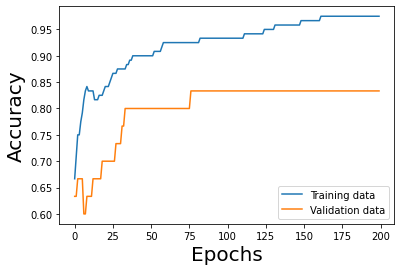

In [ ]:
plt.plot(binary_his.history['accuracy'],label='Training data')
plt.plot(binary_his.history['val_accuracy'],label='Validation data')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
binary_loss,binary_acc = binary_model.evaluate(x_test,y_test)
print('test_data accuracy : %.3f'%(binary_acc))

50/50 [==============================] - 0s 92us/step
test_data accuracy : 0.900


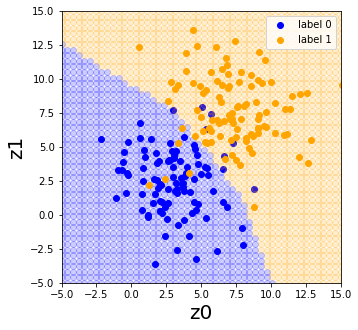

In [ ]:
def show_grid_result(data,model,grid_num,window_len,window_wid):
  grid_xdata = np.linspace(window_len,window_wid,grid_num)
  grid_ydata = np.linspace(window_len,window_wid,grid_num)
  xx,yy = np.meshgrid(grid_xdata,grid_ydata)
  grid_data = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))
  grid_data_n = (grid_data-data.mean(axis=0))/data.std(axis=0)
  grid_pred = np.argmax(model.predict(grid_data_n),axis=1)
  return grid_data,grid_pred

grid_num = 50
window_min = -5
window_max = 15
colors =['blue','orange','red','green','yellow']

grid_data,grid_pred = show_grid_result(x_data_raw,binary_model,
                                       grid_num,window_min,window_max)

plt.figure(figsize=(5,5))
#データの表示
for i in range(len(np.unique(y_target))):
  plt.scatter(grid_data[grid_pred==i,0],grid_data[grid_pred==i,1],alpha=0.2,color=colors[i])
  plt.scatter(x_data_raw[y_target==i,0],x_data_raw[y_target==i,1],label=labels[i],color=colors[i])
plt.legend(loc='upper right')

plt.xlim(window_min,window_max)
plt.ylim(window_min,window_max)
plt.xlabel('z0',fontsize=20)
plt.ylabel('z1',fontsize=20)
plt.show()
